In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import date



symbols  = [ 'SPY', "QQQ", "VGK", "SCZ", "EWJ", "EEM", #eq
           'REM', "VNQ", "RWX", # re
           'TIP', "IEF", "TLT", "BWX", #fi
           'DBC', "GLD", #como
           'twtr', 'intc', 'tsm',"VWUSX", "Amc"]

all_stocks = pd.DataFrame()
 
for symbol in symbols:
    tmp_close = yf.download(symbol, 
                      start='2020-01-01', 
                      end= date.today(),
                      interval = "1d",
                      threads = True,
                      progress=False)['Adj Close']
    all_stocks = pd.concat([all_stocks, tmp_close], axis=1)

all_stocks.columns=symbols
all_stocks

,SPY,QQQ,VGK,SCZ,EWJ,EEM,REM,VNQ,RWX,TIP,IEF,TLT,BWX,DBC,GLD,twtr,intc,tsm,VWUSX,Amc
2019-12-31,311.803253,210.392807,55.027195,59.418938,57.360989,43.318333,37.135902,86.537415,35.788078,109.723869,107.936623,131.112900,28.201143,15.950000,142.899994,32.049999,56.491615,55.706577,36.390457,7.195854
2020-01-02,314.719177,213.905792,55.487320,59.953217,57.961323,44.196861,37.169258,85.520859,35.861889,110.260368,108.436050,132.593552,28.171776,15.970000,143.949997,32.299999,57.426060,57.566658,36.906452,7.414512
2020-01-03,312.336090,211.946426,54.792435,59.199505,57.322258,43.376255,37.169258,86.052460,35.788078,110.768669,109.160721,134.635574,28.181564,16.160000,145.860001,31.520000,56.727585,55.668224,36.703434,7.275366
2020-01-06,313.527618,213.312027,54.999020,59.237671,57.525597,43.270061,37.227642,86.155045,35.871117,110.486298,109.043213,133.871063,28.230507,16.190001,147.389999,31.639999,56.567131,55.025826,36.999500,7.076585
2020-01-07,312.646057,213.282349,54.726704,59.094559,57.622421,43.241096,37.319378,85.194435,35.741951,110.147423,108.886536,133.212997,28.142410,16.180000,147.970001,32.540001,55.623245,55.917515,36.999500,7.086524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,436.630005,346.799988,62.320000,66.610001,62.939999,46.730000,31.780001,102.540001,33.470001,126.951004,112.019005,139.684998,27.177999,23.870001,178.380005,35.549999,47.700001,107.010002,54.029999,18.860001
2022-03-01,429.980011,341.489990,60.669998,65.209999,62.080002,46.110001,31.490000,102.000000,32.959999,127.860001,113.110001,141.300003,27.190001,24.830000,181.619995,35.560001,46.820000,108.050003,53.110001,18.320000
2022-03-02,437.890015,347.220001,61.610001,66.059998,62.290001,46.189999,32.080002,103.910004,33.430000,127.029999,111.410004,136.470001,26.920000,25.639999,179.729996,34.619999,48.869999,109.610001,53.660000,18.530001
2022-03-03,435.709991,342.260010,59.840000,64.750000,61.980000,45.540001,31.920000,104.760002,33.049999,126.879997,111.889999,137.860001,26.950001,25.920000,180.800003,33.490002,47.930000,108.790001,52.320000,18.059999


In [2]:
returns = np.log(all_stocks/all_stocks.shift(1))
returns.fillna(0)
returns = returns.iloc[1: , :]
returns.iloc[0:253 , :]

,SPY,QQQ,VGK,SCZ,EWJ,EEM,REM,VNQ,RWX,TIP,IEF,TLT,BWX,DBC,GLD,twtr,intc,tsm,VWUSX,Amc
2020-01-02,0.009308,0.016559,0.008327,0.008952,0.010412,0.020078,0.000898,-0.011817,0.002060,0.004878,0.004616,0.011230,-0.001042,0.001253,0.007321,0.007770,0.016406,0.032845,0.014080,0.029934
2020-01-03,-0.007601,-0.009202,-0.012602,-0.012651,-0.011087,-0.018742,0.000000,0.006197,-0.002060,0.004599,0.006661,0.015283,0.000347,0.011827,0.013181,-0.024445,-0.012238,-0.033534,-0.005516,-0.018945
2020-01-06,0.003808,0.006422,0.003763,0.000644,0.003541,-0.002451,0.001570,0.001191,0.002318,-0.002552,-0.001077,-0.005695,0.001735,0.001855,0.010435,0.003800,-0.002833,-0.011607,0.008034,-0.027703
2020-01-07,-0.002816,-0.000139,-0.004964,-0.002419,0.001682,-0.000670,0.002461,-0.011212,-0.003607,-0.003072,-0.001438,-0.004928,-0.003125,-0.000618,0.003927,0.028048,-0.016827,0.016075,0.000000,0.001404
2020-01-08,0.005315,0.007488,0.002570,-0.000323,0.000168,0.005788,-0.002909,0.003060,-0.007254,-0.000940,-0.002341,-0.006633,-0.003135,-0.014944,-0.007530,0.015551,0.000679,0.007346,0.008650,-0.074216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.003883,0.004403,0.002495,0.004881,-0.003640,-0.004379,-0.004414,0.008717,0.002380,0.000393,0.001420,0.003949,0.001934,0.002743,0.003977,-0.006096,0.010679,0.021075,0.001820,-0.019724
2020-12-28,0.008554,0.010028,0.006789,0.004269,0.010128,0.002789,0.006927,0.005943,0.006221,0.000707,0.000083,0.000445,-0.000322,-0.006183,-0.003636,0.008487,0.000000,0.001697,-0.004404,-0.048989
2020-12-29,-0.001910,0.000895,0.007234,0.008193,0.012406,0.014809,-0.012630,-0.008569,0.008528,-0.000471,-0.000167,-0.001272,0.003216,0.002753,0.003636,-0.001287,0.048112,-0.005574,-0.001523,-0.042742
2020-12-30,0.001426,0.000032,-0.001311,0.001937,0.000446,0.013240,0.006335,0.005483,0.004674,0.000785,0.000668,0.002161,0.005125,0.006167,0.007626,-0.000552,-0.013043,0.031151,0.002436,-0.058444


Prix des actions à l'instant t-1

In [3]:
vp = all_stocks[-1::].values[0]
vp

array([432.17001343, 337.29998779,  57.31000137,  62.93999863,
        61.18000031,  44.61999893,  31.73999977, 105.23999786,
        32.40999985, 127.84999847, 113.        , 140.24000549,
        26.89999962,  27.01000023, 183.67999268,  33.38999939,
        48.06999969, 105.05999756,          nan,  16.56999969])

Initialisation des variables

In [4]:
from scipy.optimize import minimize, Bounds

def init():
    
    global cash, argent_gagne, couts_transaction, s, argent_fait, pf_value, pos, pos2, Money, bounds, lamb, alpha, nb_actifs
    
    # Paramètres modifiables

    lamb = 0.01 # Coûts de transaction ; faire attention car sinon il n'y a pas de mouvements de position
    alpha = 100 # importance accordée à l'expected return
    Money = 1000 # argent alloué pour l'investissement initial
    Pos_max_par_actif = 1000 # quantité maximale d'argent investi par actif

    # Variables utilisées dans l'algorithme

    cash = 0
    win = 0
    argent_gagne = 0
    cout = 0
    couts_transaction = 0
    s = 0
    nb_actifs = returns.shape[1]
    argent_fait = []
    pf_value = 0

    # pos = portefeuille initialement vide
    pos = np.array([0 for i in range(nb_actifs)])
    pos2 = np.array([0 for i in range(nb_actifs)])
    
    # Every stock can get any position from 0 to Pos_max_par_actif
    bounds = Bounds(0, Pos_max_par_actif)

init()

Fonctions objectif et coûts de transaction

In [14]:
def objective_cov(pos):
    global s
    
    s = pos@covar_matrix@pos - alpha*expected_returns@pos
    
    # print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
    # print('\033[93m'+"Return : " + str(returns.mean()@pos) + '\033[0m')
    # print('\033[94m'+"Somme des positions: "+str(vp@pos.T)+'\033[0m')
    # print(f"Les valeurs  du vecteur poids sont:{pos.round(3)}")
    # print(f"Les valeurs de la fonction objectif:{s.round(3)}")
    return s

def objective_corr(pos):
    global s
    
    s = pos@correl_matrix@pos - alpha*expected_returns@pos
    
    # print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
    # print('\033[93m'+"Return : " + str(returns.mean()@pos) + '\033[0m')
    # print('\033[94m'+"Somme des positions: "+str(vp@pos.T)+'\033[0m')
    # print(f"Les valeurs  du vecteur poids sont:{pos.round(3)}")
    # print(f"Les valeurs de la fonction objectif:{s.round(3)}")
    return s

def TC(pos,pos2):
    return lamb*(np.sum(np.array([np.abs(pos2[i]-pos[i]) for i in range(nb_actifs)])))


Import des données roulantes à l'étape i

In [15]:
def import_donnees(etape):
    global expected_returns, correl_matrix, covar_matrix, vp, vp2
    
    # import des données roulantes
    log_returns = returns.iloc[etape:253+etape , :]
    # calcul des expected returns (on prend une période plus courte)
    expected_returns = log_returns.iloc[-15:: ,:].mean()

    # calcul de la matrice de covariance
    covar = log_returns.cov().copy()
    covar_matrix = covar.to_numpy()
    
    correl = log_returns.corr().copy()
    correl_matrix = correl.to_numpy()

    # calcul du vecteur prix des actifs à t (le temps de la décision) et t + 1jour
    vp = all_stocks[253+etape::].values[0]
    vp2 = all_stocks[254+etape::].values[0]


Calcul du portefeuille initial avec l'argent à investir

In [16]:
init()

# "ineq" says that the inequality must be non-negative.

cons = ({"type":"ineq", "fun": lambda x: Money - np.sum(np.array(x)) }, 
        # The positions must invest no more than the initial money.
        {"type": "ineq", "fun": lambda x: -(TC(pos,x)+ np.sum(x)) + Money},
        # the transactions costs must be covered by the money invested
        
        # The expected daily return of our portfolio and we want to be at greater than 0.003
        #{"type": "ineq", "fun": lambda x: -np.sum(returns.mean()*x)+1})
       )

# calcul des returns, de la matrice de variance, des vecteurs prix
import_donnees(0)

# calcul du vecteur position
p = minimize(objective_cov, pos, 
         method = "SLSQP", 
         bounds= bounds,
         constraints= cons, options={'maxiter': 300, 'ftol': 1e-09})

pos2 = p.x # les positions prises en fin de journée

couts_transaction += TC(pos,pos2)

# affichage des valeurs numériques
print("Argent injecté au départ:", Money)
# print('\033[93m'+"Return : " + str(log_returns.mean()@pos) + '\033[0m')
print('\033[92m'+"Coûts de transaction: "+str(couts_transaction)+'\033[0m')
print('\033[94m'+"Somme des positions: "+str(np.sum(pos2))+'\033[0m')
# print(f"Les valeurs  du vecteur poids sont :{pos2.round(3)}")
# print(f"La valeur de la fonction objectif est :{s.round(3)}")

# mise à jour du vecteur des positions à chaque actualisation des prix
pos = pos2
pos2 = np.array([pos[i]*vp2[i]/vp[i] for i in range(nb_actifs)])
pf_value = np.sum(pos2) # l'argent dont on dispose dans le portefeuille
argent_fait.append(pf_value)
argent_gagne += np.sum(pos2-pos) # sans compter les côuts de transaction, les bénéfices 
# réalisés par l'augmentation des valeurs des actifs
print('\033[95m'+"Argent généré sans TC : "+str(argent_gagne)+'\033[0m')
print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m', "\n")

cash = Money - np.sum(np.array(p.x)) - couts_transaction # l'argent que l'algo décide de ne pas investir
print("cash :", cash.round(6))

Argent injecté au départ: 1000
Coûts de transaction: 9.90099009900992
Somme des positions: 990.099009900992
Argent généré sans TC : 8.19006084073547
Somme des positions: 998.2890707417274 

cash : -0.0


Calcul de l'optimisation roulante

In [17]:
print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m')
print("cash :", cash.round(6), "\n")

for i in range(1,100):
    print(f"étape{i}")
    global vp, Money, pf_value, pos, pos2, argent_gagne, cout, win, cash
    
    # actualisation des positions
    pos = pos2
    
    # actualisation des contraintes
    cons = ({"type":"ineq", "fun": lambda x: Money - np.sum(np.array(x)) }, 
        # The positions must invest no more than the initial money.
        # This constraints says that the inequalities (ineq) must be non-negative.
        {"type": "ineq", "fun": lambda x: -(TC(pos,x) + np.sum((x-pos))) + cash },
        # The expected daily return of our portfolio and we want to be at greater than 0.003
        #{"type": "ineq", "fun": lambda x: -np.sum(returns.mean()*x)+1})
       )
    
    # calcul des returns, de la matrice de variance, des vecteurs prix
    import_donnees(i)
    
    # calcul du vecteur position
    p = minimize(objective_cov, pos, 
             method = "SLSQP", 
             bounds= bounds,
             constraints= cons, options={'maxiter': 300, 'ftol': 1e-09})
    
    pos2 = p.x # les positions prises en fin de journée
    
    cout = TC(pos,pos2)
    couts_transaction += cout
    pf2_value = np.sum(pos2)
    
    cash_restant = pf_value + cash - (cout + pf2_value) 
    
    cash = cash_restant # l'argent que l'algo décide de ne pas investir
    print("cash :", cash.round(6))
    
    # affichage des valeurs numériques
    # print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
    # print('\033[93m'+"Return : " + str(log_returns.mean()@pos) + '\033[0m')
    print('\033[92m'+"Coûts de transaction: "+str(couts_transaction)+'\033[0m')
    print('\033[94m'+"Somme des positions: "+str(pf2_value)+'\033[0m')
    # print(f"Les valeurs  du vecteur poids sont:{pos2.round(3)}")
    # print(f"Les valeurs de la fonction objectif:{s.round(3)}")

    # mise à jour du vecteur des positions à chaque actualisation des prix
    pos = pos2
    pos2 = np.array([pos[i]*vp2[i]/vp[i] for i in range(nb_actifs)])
    Money = np.sum(pos2) + cash
    argent_fait.append(Money)
    win = np.sum(pos2)-np.sum(pos)
    argent_gagne += win
    pf_value = np.sum(pos2)
    print('\033[95m'+"Argent généré sans TC : "+str(argent_gagne)+'\033[0m')
    print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m')
    print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")
    
    """try :
        assert (np.round(1000 + argent_gagne - couts_transaction, 6) == np.round(Money,6))
    except AssertionError :
        print(np.round(1000 + argent_gagne - couts_transaction, 6))
        print(np.round(Money,6))
        break"""

print("\n","fin du calcul")

Somme des positions: 998.2890707417274
cash : -0.0 

étape1
cash : -0.0
Coûts de transaction: 21.564930744649516
Somme des positions: 986.6251300962407
Argent généré sans TC : 11.668139061735047
Somme des positions: 990.1032083172403
Money :990.1032083170854 

étape2
cash : 0.0
Coûts de transaction: 26.500567647698233
Somme des positions: 985.1675714139168
Argent généré sans TC : 5.709002640460568
Somme des positions: 979.2084349926423
Money :979.2084349927622 

étape3
cash : 0.0
Coûts de transaction: 29.736012352454814
Somme des positions: 975.9729902880056
Argent généré sans TC : 20.957613294698405
Somme des positions: 991.2216009422434
Money :991.2216009422435 

étape4
cash : 0.0
Coûts de transaction: 33.46553591020817
Somme des positions: 987.4920773844125
Argent généré sans TC : 2.6452573704005147
Somme des positions: 969.1797214601146
Money :969.1797214601922 

étape5
cash : 30.866898
Coûts de transaction: 40.15041633524701
Somme des positions: 931.6279428679529
Argent généré san

cash : 253.701805
Coûts de transaction: 197.77890110486433
Somme des positions: 1543.6632960971583
Argent généré sans TC : 1020.5503801898865
Somme des positions: 1569.0696739039827
Money :1822.7714790850227 

étape35
cash : 344.290209
Coûts de transaction: 198.69393548666733
Somme des positions: 1477.5662357236833
Argent généré sans TC : 1025.567334549365
Somme des positions: 1482.5831900831618
Money :1826.8733990626981 

étape36
cash : 369.609964
Coûts de transaction: 199.99836525546507
Somme des positions: 1455.959005395483
Argent généré sans TC : 1034.3692837213428
Somme des positions: 1464.7609545674609
Money :1834.3709184658783 

étape37
cash : 450.858866
Coûts de transaction: 201.99410726053412
Somme des positions: 1381.5163108542645
Argent généré sans TC : 1034.0396700580404
Somme des positions: 1381.1866971909621
Money :1832.0455627975068 

étape38
cash : 904.708478
Coûts de transaction: 207.59756569295817
Somme des positions: 921.7336267325763
Argent généré sans TC : 1035.770

cash : 0.0
Coûts de transaction: 369.40613950867083
Somme des positions: 1634.9020052275164
Argent généré sans TC : 1006.2379319582366
Somme des positions: 1636.8317923379461
Money :1636.8317924495666 

étape67
cash : -0.0
Coûts de transaction: 385.4237123573071
Somme des positions: 1620.814219601114
Argent généré sans TC : 1003.817523155321
Somme des positions: 1618.3938107981985
Money :1618.3938107980148 

étape68
cash : 0.0
Coûts de transaction: 393.6527990586301
Somme des positions: 1610.1647240958036
Argent généré sans TC : 1015.6096310305626
Somme des positions: 1621.9568319710452
Money :1621.9568319719333 

étape69
cash : -0.0
Coûts de transaction: 397.4980512037432
Somme des positions: 1618.1115798268231
Argent généré sans TC : 1003.5639256054184
Somme des positions: 1606.065874401679
Money :1606.065874401676 

étape70
cash : 0.0
Coûts de transaction: 415.2971814262728
Somme des positions: 1588.266744179131
Argent généré sans TC : 1018.7759190883722
Somme des positions: 1603.47

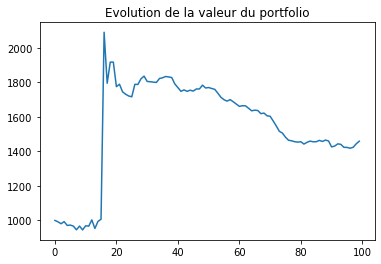

In [18]:
plt.plot(argent_fait)
plt.title("Evolution de la valeur du portfolio")
plt.show()

In [11]:
pos.round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.037, 0.   , 0.081, 0.   , 0.   , 0.267, 0.127, 0.077, 0.063,
       0.   , 1.899])

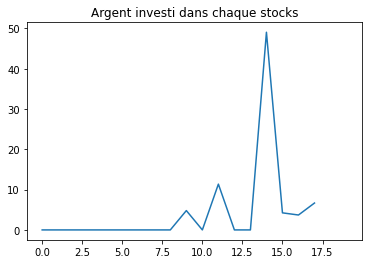

L'argent est le plus investi dans l'action: VWUSX


In [12]:
plt.plot([p.x[i] * all_stocks[-1::].values[0][i] for i in range(len(p.x))])
plt.title("Argent investi dans chaque stocks")
plt.show()
print("L'argent est le plus investi dans l'action: "+symbols[np.argmax([p.x[i] * all_stocks[-1::].values[0][i] for i in range(len(p.x))])])

In [13]:
# On a bien investi au plus Money=1000
np.dot(vp,p.x.T)

113.11001429424962

In [ ]:
# Le returns avec une telle repartition de portefeuille est de:
np.sum(returns.mean()*p.x)

In [ ]:
print("Nombre d'action acheté pour chaque symbols: ")
r = pd.DataFrame([symbols,p.x])
for i in range(len(symbols)):
    print(symbols[i],p.x[i].round(3))